### Using UCC on FakeTorino


In [1]:
from qiskit import QuantumCircuit
from qiskit import transpile as qiskit_transpile
from qiskit_ibm_runtime.fake_provider import FakeTorino
from qiskit_aer import AerSimulator

In [2]:
%matplotlib inline

In [3]:
# 1. Initialize the fake backend
fake_backend = FakeTorino()

num_qubits = 3
num_shots = 5000

In [4]:
# 2. Create a quantum circuit
def ghz_circuit(num_qubits=3):
    qc = QuantumCircuit(num_qubits)
    qc.h(0)
    for i in range(1, num_qubits):
        qc.cx(0, i)
    
    # for i in range(1, num_qubits):
    qc.measure_all()
    
    return qc

In [5]:
print(ghz_circuit(num_qubits=num_qubits))

        ┌───┐           ░ ┌─┐      
   q_0: ┤ H ├──■────■───░─┤M├──────
        └───┘┌─┴─┐  │   ░ └╥┘┌─┐   
   q_1: ─────┤ X ├──┼───░──╫─┤M├───
             └───┘┌─┴─┐ ░  ║ └╥┘┌─┐
   q_2: ──────────┤ X ├─░──╫──╫─┤M├
                  └───┘ ░  ║  ║ └╥┘
meas: 3/═══════════════════╩══╩══╩═
                           0  1  2 


In [6]:
import ucc
import re

def run_circuit(qc, simulator, compiler_name, shots=num_shots):
    if compiler_name == 'ucc':
        compiled_qc = ucc.compile(qc, target_device=fake_backend.target)
    elif compiler_name == 'qiskit':
        compiled_qc = qiskit_transpile(qc, fake_backend)
    
    # 5. Run the compiled circuit on the simulator
    job = simulator.run(compiled_qc, shots=shots)
    result = job.result()
    counts = result.get_counts(compiled_qc)

    if "(" in simulator.name: # remove the "from_backend" part of the string
        simulator_name = re.findall(r'\(([^]]*)\)', simulator.name)[0]
    else: 
        simulator_name = 'ideal'
        
    return (compiler_name + '-' + simulator_name, counts)

/Users/jordansullivan/UnitaryFund/research/ucc-hw-aware/.venv/lib/python3.13/site-packages/qbraid/_entrypoints.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [7]:
# 3. Create an AerSimulator with the noise model of the fake backend
# This allows for noisy simulation mimicking the real hardware.
backend_simulator = AerSimulator.from_backend(fake_backend)

results = []
qc = ghz_circuit(num_qubits)

# 4. Compile and simulate with UCC
results.append(run_circuit(qc, backend_simulator, 'ucc', num_shots))

# 5. Compile and simulate with Qiskit
qc =  ghz_circuit(num_qubits)
results.append(run_circuit(qc, backend_simulator, 'qiskit', num_shots))

/Users/jordansullivan/UnitaryFund/research/ucc-hw-aware/.venv/lib/python3.13/site-packages/ucc/compile.py:73: UserWarning: Warning: The target gateset None is not supported by the target device. 
  warnings.warn(


In [8]:
# 6. Compile and simulate noise-free with UCC
ideal_simulator = AerSimulator(method='statevector')

qc = ghz_circuit(num_qubits) 
results.append(run_circuit(qc, ideal_simulator, 'ucc', num_shots))

# 7. Compile and simulate noise-free with Qiskit
qc = ghz_circuit(num_qubits) 
results.append(run_circuit(qc, ideal_simulator, 'qiskit', num_shots))

/Users/jordansullivan/UnitaryFund/research/ucc-hw-aware/.venv/lib/python3.13/site-packages/ucc/compile.py:73: UserWarning: Warning: The target gateset None is not supported by the target device. 
  warnings.warn(


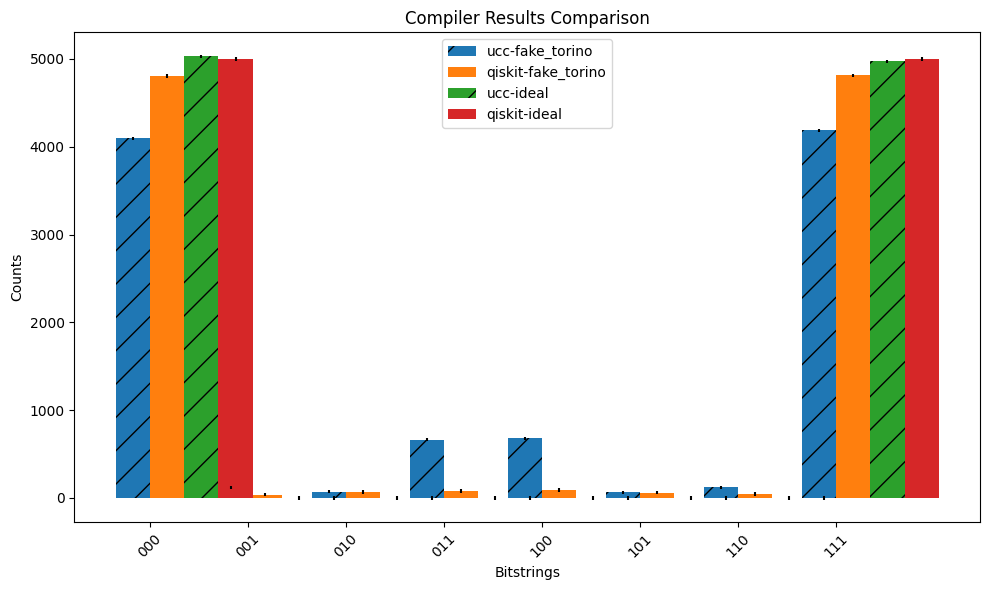

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Your data
data = results
# Extract binary strings (keys) and sort them
binary_strings = sorted(data[0][1].keys())
compilers = [item[0] for item in data]

# Prepare data for plotting
values = []
for compiler, counts in data:
    values.append([counts.get(b, 0) for b in binary_strings])

# Set up the plot
x = np.arange(len(binary_strings))
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for each compiler
for i, (compiler, compiler_values) in enumerate(zip(compilers, values)):
    offset = width * i
    pattern = ['/'] if 'ucc' in compiler else ['']
    # color = 'b' if 'ideal' in compiler else 'g'
    std_dev = np.std(compiler_values)
    errors = [(std_dev/(num_shots)**(1/2)) for _ in compiler_values]

    ax.bar(x + offset, compiler_values, width, label=compiler, hatch=pattern, yerr=errors) #, color=color)

# Customize the plot
ax.set_xlabel("Bitstrings")
ax.set_ylabel("Counts")
ax.set_title("Compiler Results Comparison")
ax.set_xticks(x + width / 2)
ax.set_xticklabels(binary_strings, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

## Plot Errors

In [10]:
data

[('ucc-fake_torino',
  {'101': 64,
   '110': 121,
   '001': 123,
   '100': 678,
   '011': 663,
   '111': 4185,
   '000': 4096,
   '010': 70}),
 ('qiskit-fake_torino',
  {'001': 38,
   '110': 42,
   '100': 92,
   '101': 59,
   '111': 4812,
   '011': 81,
   '010': 67,
   '000': 4809}),
 ('ucc-ideal', {'111': 4972, '000': 5028}),
 ('qiskit-ideal', {'000': 4997, '111': 5003})]

In [33]:
print(data[0][0])

ucc-fake_torino


In [31]:
# Plot errors
# Prepare data for plotting

ideal_values, noisy_values = [], []
ideal_compilers, noisy_compilers = [], []

for compiler, counts in data:
    if 'ideal' in compiler:
        ideal_compilers.append(compiler)
        ideal_values.append([counts.get(b, 0) for b in binary_strings])
    else:
        noisy_compilers.append(compiler)
        noisy_values.append([counts.get(b, 0) for b in binary_strings])

print(noisy_values)


[[4096, 123, 70, 663, 678, 64, 121, 4185], [4809, 38, 67, 81, 92, 59, 42, 4812]]


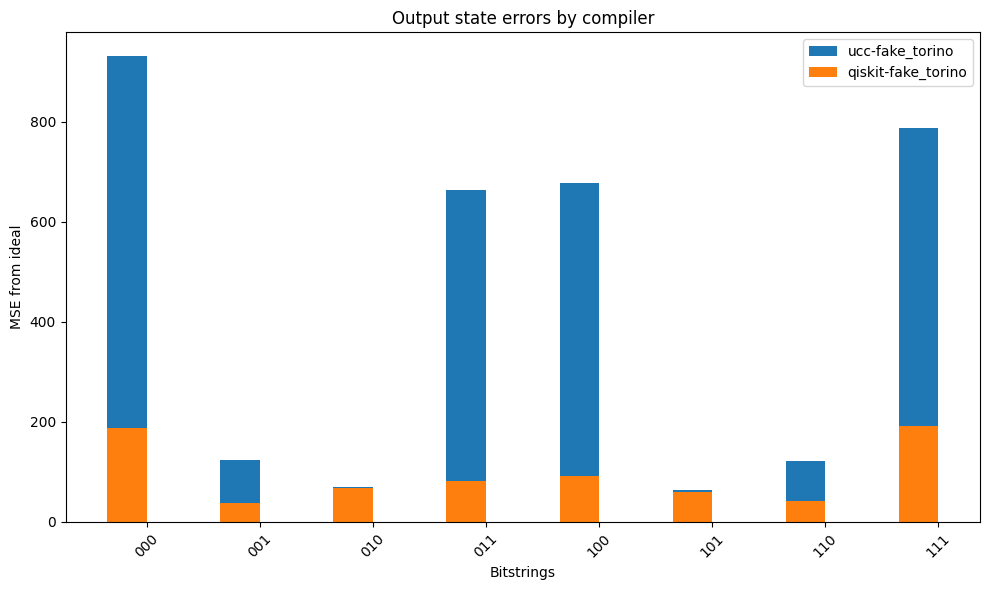

In [38]:

# Set up the plot
x = np.arange(len(binary_strings))
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# for i, (compiler, compiler_values) in enumerate(zip(compilers, values)):

for id_val, nois_val, id_comp, nois_comp in zip(np.array(ideal_values), np.array(noisy_values), np.array(ideal_compilers), np.array(noisy_compilers)):
    errors = ((id_val - nois_val)**2)**(1/2)
    
    ax.bar(x + offset, errors, width, label=nois_comp) #, hatch=pattern, color=color)
    
    
# Customize the plot
ax.set_xlabel("Bitstrings")
ax.set_ylabel("MSE from ideal")
ax.set_title("Output state errors by compiler")
ax.set_xticks(x + width / 2)
ax.set_xticklabels(binary_strings, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

### Next steps
Since it appears UCC is doing worse than Qiskit in this case, we most likely next wish to run our full ucc-bench benchmarks on these devices to compare performance